# Semi-supervised Contrastive learning

 Image a situation where a vision dataset contains a large number of unlabeled images and only a small number of labeled images. A model's performance only scales sublinearly with the amount of data as the model might start overfitting. If unlabeled data could be used to train a model, a larger data distribution would be available to train upon and training cost can be reduced significantly as a labeled dataset can cost much higher than an unlabeled set.

Semi-supervised learning offers to solve this problem by only requiring a partially labeled dataset, and by being label-efficient by utilizing the unlabeled examples for learning as well.

Contrastive learning uses contracting positives (representations of augmented versions/views of the same image closer to each other), while performing contrasting negatives (pushing different images away from each other  in representation space).

Lets combine these two techniques to achive better performance with a small number of labeled images and a much larger set of unlabeled images.

In [ ]:
!pip install -q tfimm

In [2]:
import math
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras import layers
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import os
tf.config.set_soft_device_placement(True)
import tfimm

In [7]:
SEED = 1
AUTO = tf.data.AUTOTUNE

GCS_PATH = 'gs://kds-57f9ca82c6ece747fdb97da243e70f5c8414ca9cf66a8576e6c00740'
VERBOSE = 1
train = pd.read_csv('train.csv')
N_CLASSES = train.species.nunique()
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/train/*.png')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/test/*.png')
FRAC = 0.02      # Small fraction of labeled images
NFOLD = 5
VAL_FOLD = 0
TEST_FOLD = 1

# Dataset hyperparameters
unlabeled_dataset_size = len(TEST_FILENAMES)
labeled_dataset_size = int(len(TEST_FILENAMES)*0.05)
image_size = 64
image_channels = 3
LR = 2e-4

# Algorithm hyperparameters
num_epochs = 20
batch_size = 512
width = 128
temperature = 0.1
# Stronger augmentations for contrastive, weaker ones for supervised training
contrastive_augmentation = {"min_area": 0.25, "brightness": 0.6, "jitter": 0.2}
classification_augmentation = {"min_area": 0.75, "brightness": 0.3, "jitter": 0.1}

def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
seed_everything(SEED)

In [ ]:
from IPython.display import clear_output

tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

clear_output()    

# Dataset

In [8]:
train = pd.read_csv('train.csv')

encoder = LabelEncoder()
train['labels'] = encoder.fit_transform(train.species)

gkf  = GroupKFold(n_splits = NFOLD)
train['fold'] = -1
for fold, (train_idx, val_idx) in enumerate(gkf.split(train, groups = train.individual_id.tolist())):
    train.loc[val_idx, 'fold'] = fold

train.head(1)

,image,species,individual_id,labels,fold
0,00021adfb725ed.jpg,melon_headed_whale,cadddb1636b9,18,2


# Image augmentations

- Cropping: Using RandomTranslation and RandomZoom to encode different parts of the same image similarly.

- Color jitter: Using affine transformations in color space to prevent a trivial color histogram-based solution to the task by distorting color histograms. 

- Random horizontal flips

Stronger augmentations are applied for contrastive learning, along with weaker ones for supervised classification to avoid overfitting on the few labeled examples.

Unlike in the reference notebook, we create seperate datasets for labeled and unlabeled data for contrastive and classification each. The reason being that random implementations cannot be run in a XLA environment. The overall time taken to train using a tpu was much less when compared to a gpu.

In [9]:
valid_paths = [GCS_PATH+'/train/train/'+x[0]+'.png' for x in train[train['fold'] == VAL_FOLD]['image'].str.split('.').values]
train_paths = [GCS_PATH+'/train/train/'+x[0]+'.png' for x in train[(train['fold'] != VAL_FOLD) & (train['fold'] != TEST_FOLD)]['image'].str.split('.').values][0:int(len(TRAINING_FILENAMES)*FRAC)]
test_paths = [GCS_PATH+'/train/train/'+x[0]+'.png' for x in train[train['fold'] == TEST_FOLD]['image'].str.split('.').values]

valid_labels = tf.one_hot(train[train['fold'] == VAL_FOLD]['labels'].values, N_CLASSES).numpy()
train_labels = tf.one_hot(train[(train['fold'] != VAL_FOLD) & (train['fold'] != TEST_FOLD)]['labels'].values, N_CLASSES).numpy()[0:int(len(TRAINING_FILENAMES)*FRAC)]
test_labels = tf.one_hot(train[train['fold'] == TEST_FOLD]['labels'].values, N_CLASSES).numpy()
pseudo_labels = np.array([-1]*len(TEST_FILENAMES)).reshape(-1,1)

def decode_img(path):
    file_bytes = tf.io.read_file(path)
    img = tf.image.decode_png(file_bytes, channels=3)
    img = tf.image.resize(img, [image_size,image_size] )
    img = tf.cast(img, tf.float32) / 255
    return img

def print_score(score, m):
  return print(f'Test accuracy for {m}: {score*100}%')
  
def load_dataset(filename,labels):
    img = decode_img(filename)
    return img, labels

def get_augmenter(x, min_area, brightness, jitter):
    zoom_factor = 1.0 - math.sqrt(min_area)
    return keras.Sequential(
        [
            layers.RandomFlip("horizontal"),
            layers.RandomTranslation(zoom_factor / 2, zoom_factor / 2),
            layers.RandomZoom((-zoom_factor, 0.0), (-zoom_factor, 0.0)),
            RandomColorAffine(brightness, jitter),
        ]
    )(x)

# Distorts the color distibutions of images
class RandomColorAffine(layers.Layer):
    def __init__(self, brightness=0, jitter=0, **kwargs):
        super().__init__(**kwargs)

        self.brightness = brightness
        self.jitter = jitter

    def get_config(self):
        config = super().get_config()
        config.update({"brightness": self.brightness, "jitter": self.jitter})
        return config

    def call(self, images, training=True):
        if training:
            batch_size = tf.shape(images)[0]

            # Same for all colors
            brightness_scales = 1 + tf.random.uniform(
                (batch_size, 1, 1, 1), minval=-self.brightness, maxval=self.brightness
            )
            # Different for all colors
            jitter_matrices = tf.random.uniform(
                (batch_size, 1, 3, 3), minval=-self.jitter, maxval=self.jitter
            )

            color_transforms = (
                tf.eye(3, batch_shape=[batch_size, 1]) * brightness_scales
                + jitter_matrices
            )
            images = tf.clip_by_value(tf.matmul(images, color_transforms), 0, 1)
        return images

def prepare_dataset():
    # Labeled and unlabeled samples are loaded synchronously
    # with batch sizes selected accordingly
    steps_per_epoch = (unlabeled_dataset_size + labeled_dataset_size) // batch_size
    unlabeled_batch_size = unlabeled_dataset_size // steps_per_epoch
    labeled_batch_size = labeled_dataset_size // steps_per_epoch
    print(
        f"batch size is {unlabeled_batch_size} (unlabeled) + {labeled_batch_size} (labeled)"
    )

    unlabeled_contrastive = tf.data.Dataset.from_tensor_slices((TEST_FILENAMES, pseudo_labels)) \
        .map(load_dataset, num_parallel_calls = AUTO).cache() \
        .shuffle(buffer_size=10 * unlabeled_batch_size) \
        .batch(unlabeled_batch_size) \
        .map(lambda x, y: (get_augmenter(x, **contrastive_augmentation), y))

    labeled_contrastive = tf.data.Dataset.from_tensor_slices((train_paths, train_labels)) \
        .map(load_dataset, num_parallel_calls = AUTO).cache() \
        .shuffle(buffer_size=10 * labeled_batch_size) \
        .batch(labeled_batch_size) \
        .map(lambda x, y: (get_augmenter(x, **contrastive_augmentation), y))

    unlabeled_classification = tf.data.Dataset.from_tensor_slices((TEST_FILENAMES, pseudo_labels)) \
        .map(load_dataset, num_parallel_calls = AUTO).cache() \
        .shuffle(buffer_size=10 * unlabeled_batch_size) \
        .batch(unlabeled_batch_size) \
        .map(lambda x, y: (get_augmenter(x, **classification_augmentation), y))

    labeled_classification = tf.data.Dataset.from_tensor_slices((train_paths, train_labels)) \
        .map(load_dataset, num_parallel_calls = AUTO).cache() \
        .shuffle(buffer_size=10 * labeled_batch_size) \
        .batch(labeled_batch_size) \
        .map(lambda x, y: (get_augmenter(x, **classification_augmentation), y))

    labeled_train = tf.data.Dataset.from_tensor_slices((train_paths, train_labels)) \
        .map(load_dataset, num_parallel_calls = AUTO).cache() \
        .shuffle(buffer_size=10 * labeled_batch_size) \
        .batch(labeled_batch_size)       

    valid_dataset = tf.data.Dataset.from_tensor_slices((valid_paths, valid_labels)) \
        .map(load_dataset, num_parallel_calls = AUTO).cache() \
        .batch(batch_size)

    test_dataset = tf.data.Dataset.from_tensor_slices((test_paths, test_labels)) \
        .map(load_dataset, num_parallel_calls = AUTO).cache() \
        .batch(batch_size)

    # Labeled and unlabeled datasets are zipped together
    train_dataset = tf.data.Dataset.zip(
        (unlabeled_classification, labeled_classification, unlabeled_contrastive, labeled_contrastive)
    ).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

    return train_dataset, labeled_classification, labeled_contrastive, valid_dataset, test_dataset, labeled_train


# Load STL10 dataset
train_dataset, labeled_classification, labeled_contrastive, valid_dataset, test_dataset, labeled_train = prepare_dataset()   
print(f'Number of labeled images: {len(train_labels)} \nNumber of unlabeled images: {len(pseudo_labels)}') 

batch size is 490 (unlabeled) + 24 (labeled)
Number of labeled images: 1020 
Number of unlabeled images: 27956


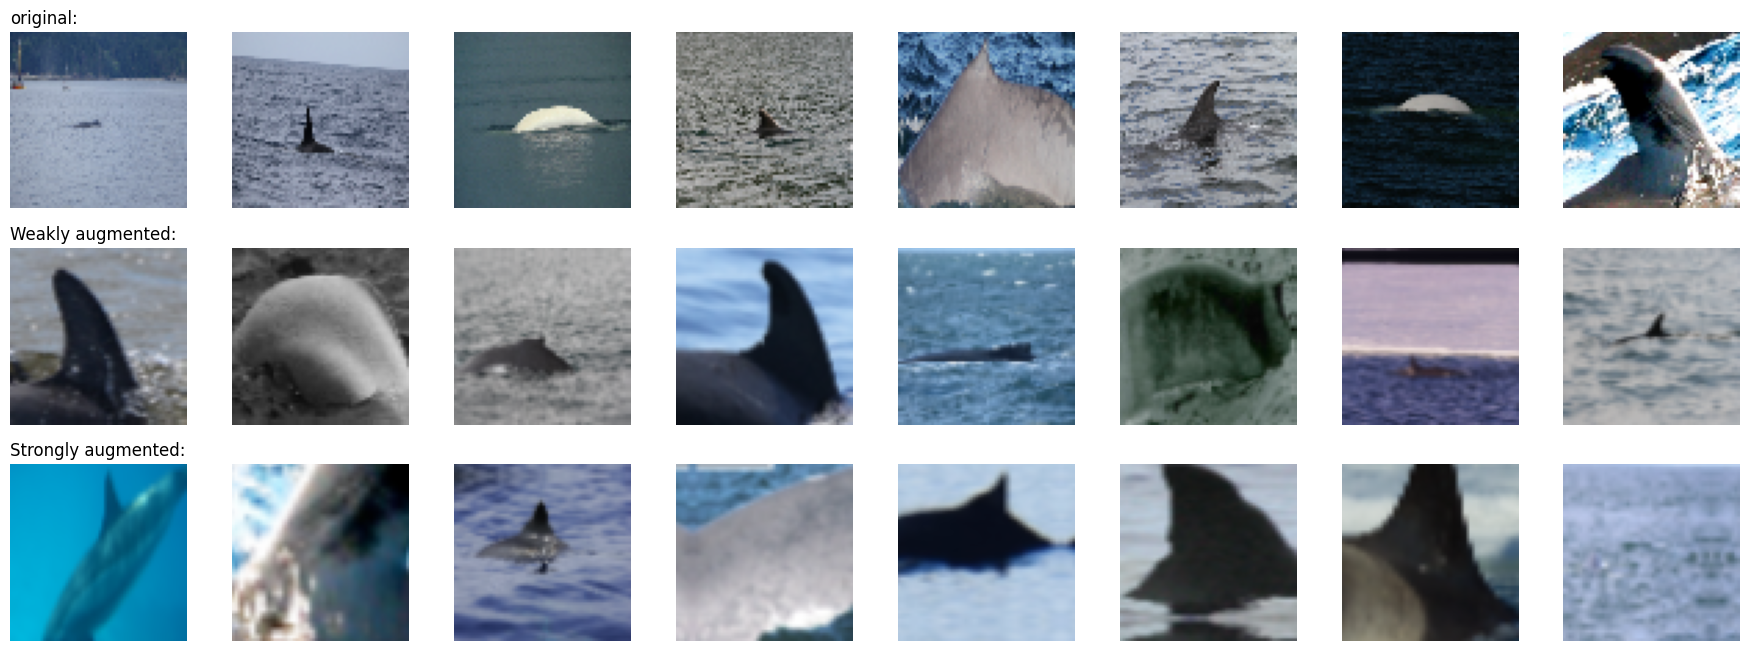

In [ ]:
# The classification accuracies of the baseline and the pretraining + finetuning process:
def plot_training_curves(pretraining_history, finetuning_history, baseline_history):
    for metric_key, metric_name in zip(["accuracy", "loss"], ["accuracy", "loss"]):
        plt.figure(figsize=(8, 5), dpi=100)
        plt.plot(
            baseline_history.history[f"val_{metric_key}"], label="supervised baseline"
        )
        plt.plot(
            pretraining_history.history[f"val_p_{metric_key}"],
            label="self-supervised pretraining",
        )
        plt.plot(
            finetuning_history.history[f"val_{metric_key}"],
            label="supervised finetuning",
        )
        plt.legend()
        plt.title(f"Classification {metric_name} during training")
        plt.xlabel("epochs")
        plt.ylabel(f"validation {metric_name}")
        
def visualize_augmentations(num_images):
    # Sample a batch from a dataset
    images = next(iter(labeled_train))[0][:num_images]
    images1 = next(iter(labeled_classification))[0][:num_images]
    images2 = next(iter(labeled_contrastive))[0][:num_images]

    # Apply augmentations
    augmented_images = zip(images,images1,images2)
    row_titles = [
        "original:",
        "Weakly augmented:",
        "Strongly augmented:",
    ]
    plt.figure(figsize=(num_images * 2.2, 4 * 2.2), dpi=100)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(4, num_images, row * num_images + column + 1)
            plt.imshow(image)
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")
    plt.tight_layout()


visualize_augmentations(num_images=8)

# Encoder

In [ ]:
# Define the encoder architecture
def get_encoder():
    return keras.Sequential(
        [
            keras.Input(shape=(image_size, image_size, image_channels)),
            tfimm.create_model('resnet34d'),
            layers.Dense(width),
        ],
        name="encoder",
    )

# Supervised baseline model

In [ ]:
# Baseline supervised training with random initialization
with strategy.scope():
  baseline_model = keras.Sequential(
    [
        keras.Input(shape=(image_size, image_size, image_channels)),
        get_encoder(),
        layers.Dense(N_CLASSES),
    ],
    name="baseline_model",
    )
  baseline_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")],
    )
  
baseline_history = baseline_model.fit(
    labeled_classification, epochs=num_epochs, validation_data=valid_dataset, validation_freq = 2
)

print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(baseline_history.history["val_accuracy"]) * 100
    )
)

Epoch 1/20
59/59 [==============================] - 96s 838ms/step - loss: 2.5473 - accuracy: 0.2836
Epoch 2/20
59/59 [==============================] - 256s 4s/step - loss: 2.2499 - accuracy: 0.3493 - val_loss: 2.9375 - val_accuracy: 0.3682
Epoch 3/20
59/59 [==============================] - 2s 30ms/step - loss: 2.1193 - accuracy: 0.3950
Epoch 4/20
59/59 [==============================] - 3s 53ms/step - loss: 1.9926 - accuracy: 0.4364 - val_loss: 3.1218 - val_accuracy: 0.3856
Epoch 5/20
59/59 [==============================] - 2s 29ms/step - loss: 1.9248 - accuracy: 0.4536
Epoch 6/20
59/59 [==============================] - 3s 52ms/step - loss: 1.7976 - accuracy: 0.4793 - val_loss: 2.0685 - val_accuracy: 0.4690
Epoch 7/20
59/59 [==============================] - 2s 30ms/step - loss: 1.7517 - accuracy: 0.4879
Epoch 8/20
59/59 [==============================] - 3s 52ms/step - loss: 1.6869 - accuracy: 0.5121 - val_loss: 2.0831 - val_accuracy: 0.4838
Epoch 9/20
59/59 [====================

# Pre-train an encoder with Contrastive Learning

Self-supervise train an encoder using unlabeled images with a contrastive loss. A resnet34d architecture is used with a nonlinear projection head attached to the top of the encoder, as it improves the quality of representations of the encoder.

1. We treat each image in the batch as if it had its own class.
2. Then, we have two examples (a pair of augmented views) for each "class".
3. Each view's representation is compared to every possible pair's one (for both augmented versions).
4. We use the temperature-scaled cosine similarity of compared representations as logits.
5. Finally, we use categorical cross-entropy as the "classification" loss

The following two metrics are used for monitoring the pretraining performance:

- [Contrastive accuracy](https://arxiv.org/abs/2002.05709)

- [Linear probing accuracy](https://arxiv.org/abs/1603.08511)


In [ ]:
# Define the contrastive model with model-subclassing
class ContrastiveModel(keras.Model):
    def __init__(self):
        super().__init__()

        self.temperature = temperature
        self.encoder = get_encoder()
        # Non-linear MLP as projection head
        self.projection_head = keras.Sequential(
            [
                keras.Input(shape=(width,)),
                layers.Dense(width, activation="relu"),
                layers.Dense(width),
            ],
            name="projection_head",
        )
        # Single dense layer for linear probing
        self.linear_probe = keras.Sequential(
            [layers.Input(shape=(width,)), layers.Dense(N_CLASSES)], name="linear_probe"
        )

        self.encoder.summary()
        self.projection_head.summary()
        self.linear_probe.summary()

    def compile(self, contrastive_optimizer, probe_optimizer, probe_loss, contrastive_loss, contrastive_loss_tracker, contrastive_accuracy, 
                probe_loss_tracker, probe_accuracy, **kwargs):
        super().compile(**kwargs)

        self.contrastive_optimizer = contrastive_optimizer
        self.probe_optimizer = probe_optimizer

        self.probe_loss = probe_loss
        self.contrastive_loss = contrastive_loss
        self.contrastive_loss_tracker = contrastive_loss_tracker
        self.contrastive_accuracy = contrastive_accuracy
        self.probe_loss_tracker = probe_loss_tracker
        self.probe_accuracy = probe_accuracy

    @property
    def metrics(self):
        return [
            self.contrastive_loss_tracker,
            self.contrastive_accuracy,
            self.probe_loss_tracker,
            self.probe_accuracy,
        ]

    def contrastive_param(self, projections_1, projections_2):
        # InfoNCE loss (information noise-contrastive estimation)
        # NT-Xent loss (normalized temperature-scaled cross entropy)

        # Cosine similarity: the dot product of the l2-normalized feature vectors
        projections_1 = tf.math.l2_normalize(projections_1, axis=1)
        projections_2 = tf.math.l2_normalize(projections_2, axis=1)
        similarities = (
            tf.matmul(projections_1, projections_2, transpose_b=True) / self.temperature
        )

        # The similarity between the representations of two augmented views of the
        # same image should be higher than their similarity with other views
        batch_size = tf.shape(projections_1)[0]
        contrastive_labels = tf.range(batch_size)
        self.contrastive_accuracy.update_state(contrastive_labels, similarities)
        self.contrastive_accuracy.update_state(
            contrastive_labels, tf.transpose(similarities)
        )

        return contrastive_labels, similarities

    def train_step(self, data):
        (unlabeled_images_classification, _), (labeled_images_classification, labels), \
        (unlabeled_images_contrastive, _), (labeled_images_contrastive, _) = data

        # Both labeled and unlabeled images are used, without labels
        images = tf.concat((unlabeled_images_contrastive, labeled_images_contrastive), axis=0)
        # Each image is augmented twice, differently
        augmented_images_1 = images
        augmented_images_2 = images
        with tf.GradientTape() as tape:
            features_1 = self.encoder(augmented_images_1, training=True)
            features_2 = self.encoder(augmented_images_2, training=True)
            # The representations are passed through a projection mlp
            projections_1 = self.projection_head(features_1, training=True)
            projections_2 = self.projection_head(features_2, training=True)

            contrastive_labels, similarities = self.contrastive_param(projections_1, projections_2)
            loss_1_2 = self.contrastive_loss(contrastive_labels, similarities)
            loss_2_1 = self.contrastive_loss(contrastive_labels, tf.transpose(similarities))
            contrastive_loss = (loss_1_2 + loss_2_1) / 2

        gradients = tape.gradient(
            contrastive_loss,
            self.encoder.trainable_weights + self.projection_head.trainable_weights,
        )
        self.contrastive_optimizer.apply_gradients(
            zip(
                gradients,
                self.encoder.trainable_weights + self.projection_head.trainable_weights,
            )
        )
        self.contrastive_loss_tracker.update_state(contrastive_loss)

        # Labels are only used in evalutation for an on-the-fly logistic regression
        preprocessed_images = labeled_images_classification

        with tf.GradientTape() as tape:
            # the encoder is used in inference mode here to avoid regularization
            # and updating the batch normalization paramers if they are used
            features = self.encoder(preprocessed_images, training=False)
            class_logits = self.linear_probe(features, training=True)
            probe_loss = self.probe_loss(labels, class_logits)
        gradients = tape.gradient(probe_loss, self.linear_probe.trainable_weights)
        self.probe_optimizer.apply_gradients(
            zip(gradients, self.linear_probe.trainable_weights)
        )
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        labeled_images, labels = data

        # For testing the components are used with a training=False flag
        preprocessed_images = labeled_images

        features = self.encoder(preprocessed_images, training=False)
        class_logits = self.linear_probe(features, training=False)
        probe_loss = self.probe_loss(labels, class_logits)
        self.probe_loss_tracker.update_state(probe_loss)
        self.probe_accuracy.update_state(labels, class_logits)

        # Only the probe metrics are logged at test time
        return {m.name: m.result() for m in self.metrics[2:]}

# Contrastive pretraining
with strategy.scope():
  pretraining_model = ContrastiveModel()
  pretraining_model.compile(
    contrastive_optimizer=keras.optimizers.Adam(learning_rate=LR),
    probe_optimizer=keras.optimizers.Adam(learning_rate=LR),
    probe_loss = keras.losses.CategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE),
    contrastive_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE),
    contrastive_loss_tracker = keras.metrics.Mean(name="c_loss"),
    contrastive_accuracy = keras.metrics.CategoricalAccuracy(name="c_accuracy"),
    probe_loss_tracker = keras.metrics.Mean(name="p_loss"),
    probe_accuracy = keras.metrics.CategoricalAccuracy(name="p_accuracy")
  )

pretraining_history = pretraining_model.fit(
    train_dataset, epochs=num_epochs, validation_data=valid_dataset, validation_freq = 2
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(pretraining_history.history["val_p_accuracy"]) * 100
    )
)

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 64, 64, 3)         0         
                                                                 
 res_net_1 (ResNet)          (None, 1000)              21834056  
                                                                 
 dense_2 (Dense)             (None, 128)               128128    
                                                                 
Total params: 21,962,184
Trainable params: 21,945,032
Non-trainable params: 17,152
_________________________________________________________________
Model: "projection_head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dense_4 (Dense) 

# Finetune the pretrained encoder



In [ ]:
with strategy.scope():
  finetuning_model = keras.Sequential(
    [
        layers.Input(shape=(image_size, image_size, image_channels)),
        pretraining_model.encoder,
        layers.Dense(N_CLASSES),
    ],
    name="finetuning_model",
    )
  finetuning_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LR),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.CategoricalAccuracy(name="accuracy")],
    )

finetuning_history = finetuning_model.fit(
    labeled_classification, epochs=num_epochs, validation_data=valid_dataset, validation_freq = 2
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history.history["val_accuracy"]) * 100
    )
)

Epoch 1/20
59/59 [==============================] - 64s 430ms/step - loss: 2.4685 - accuracy: 0.3157
Epoch 2/20
59/59 [==============================] - 13s 217ms/step - loss: 2.1381 - accuracy: 0.3879 - val_loss: 2.4893 - val_accuracy: 0.3865
Epoch 3/20
59/59 [==============================] - 2s 30ms/step - loss: 1.9575 - accuracy: 0.4421
Epoch 4/20
59/59 [==============================] - 3s 53ms/step - loss: 1.8572 - accuracy: 0.4543 - val_loss: 2.2707 - val_accuracy: 0.4499
Epoch 5/20
59/59 [==============================] - 2s 30ms/step - loss: 1.7508 - accuracy: 0.4936
Epoch 6/20
59/59 [==============================] - 4s 64ms/step - loss: 1.7143 - accuracy: 0.4971 - val_loss: 2.1859 - val_accuracy: 0.4535
Epoch 7/20
59/59 [==============================] - 2s 30ms/step - loss: 1.6918 - accuracy: 0.5071
Epoch 8/20
59/59 [==============================] - 3s 53ms/step - loss: 1.5928 - accuracy: 0.5307 - val_loss: 2.2585 - val_accuracy: 0.4721
Epoch 9/20
59/59 [==================

In [ ]:
_, base_acc = baseline_model.evaluate(test_dataset, verbose=0)
_, pt_acc = pretraining_model.evaluate(test_dataset, verbose=0)
_, ft_acc = finetuning_model.evaluate(test_dataset, verbose=0)

print_score(base_acc, 'base model')  
print_score(pt_acc, 'simclr')  
print_score(ft_acc, 'finetuned simclr')  

Test accuracy for base model: 55.69707155227661%
Test accuracy for simclr: 9.542470425367355%
Test accuracy for finetuned simclr: 56.471049785614014%


#### The accuracy does improve even when the datasets (labeled and unlabeled) have similar distributions.

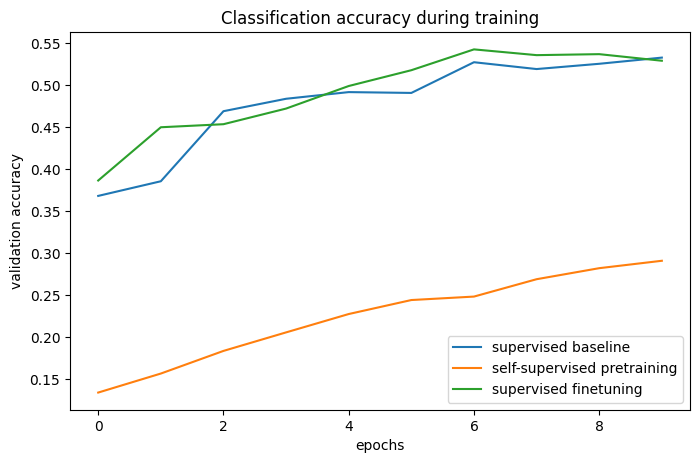

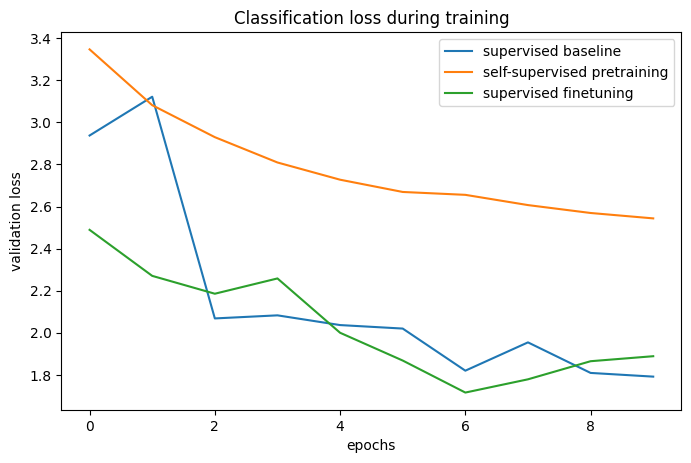

In [ ]:
plot_training_curves(pretraining_history, finetuning_history, baseline_history)